# Thetis Accelerometer Validation
This notebook will compare the measured accelerations captured by a reference accelerometer to that of the Thetis accelerometer using several statistical metrics.

The waveform generator will create a sinusoidal waveform at a given frequency, f, (maximum 20 Hz) that is sent to the amplifier. The amplifier then converts that to a signal that drives the vibration table at a higher amplitude.

At lower frequencies, the vibration table is unable to generate a clean sine wave signal. Therefore, another accelerometer of known calibration was attached to the vibration table in the axis of movement to act as a ground truth reference. It is this ground truth that will be compared with the Thetis data to validate the instrument.
Data is recorded from the accelerometer using the oscilloscope. These data files are saved as CSVs that can be plotted alongside the Thetis data.

### CHANGELOG:
 - Version 1.0: Initial Release
 - Version 2.0: Revamped to account for new testing procedure

### TODO:
 - 

In [7]:
# Import libraries and declare constants
from ctypes import sizeof
from util import ThetisData
import matplotlib.pyplot as plt
import datetime as dt
from math import pi
import numpy as np
import pandas as pd
from scipy import signal

DATASETS = ["x", "y", "z"]
FREQUENCIES = ["1_0", "2_0", "3_0", "4_0", "5_0", "6_0", "7_0", "8_0", "9_0", "10_0", "11_0", "12_0", "13_0", "14_0", "15_0", "16_0"]
CURRENT_DATASET = "x" # x, y, z
CURRENT_FREQUENCY = "3_0" # 3_0, 3_5, 4_0, 4_5...16_0, 17_0, 18_0...24_0

DAQ_FILEPATH = "data/{0}-axis/{0}_daq_{1}Hz.csv".format(CURRENT_DATASET, CURRENT_FREQUENCY)
THETIS_FILEPATH = "data/{0}-axis/{0}_thetis_{1}Hz.bin".format(CURRENT_DATASET, CURRENT_FREQUENCY)


## Read in the Experimental Data

In [8]:
# Read data from DAQ file
daq_data = pd.read_csv(DAQ_FILEPATH, names=["time", "accel"], header=1)

# Read data from Thetis data file
with open(THETIS_FILEPATH, "rb") as file:
    epoch_data = []
    raw_accel_data = []
    accel_data = []

    data = ThetisData()
    while file.readinto(data) == sizeof(data):
        timestamp = dt.datetime.utcfromtimestamp(data.epoch) + dt.timedelta(milliseconds=data.mSecond)
        epoch_data.append(timestamp)
        if CURRENT_DATASET == "x":
            raw_accel_data.append(data.rawAccelX)
        if CURRENT_DATASET == "y":
            raw_accel_data.append(data.rawAccelY)
        if CURRENT_DATASET == "z":
            raw_accel_data.append(data.rawAccelZ)

epoch_data = np.array(epoch_data)
raw_accel_data = np.array(raw_accel_data)

## Graph Data

[0.0000e+00 3.0000e-03 1.3000e-02 ... 4.3829e+01 4.3840e+01 4.3860e+01]
Number of samples:  6320
Total Sample Time:  31.52
Average Sample Rate:  144
-31


Text(0, 0.5, 'Signal-to-Noise Ratio [dB]')

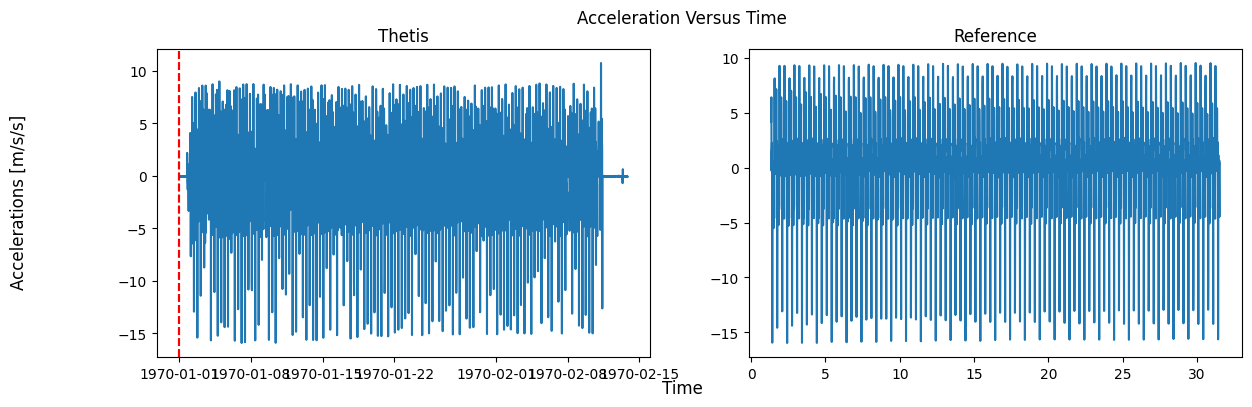

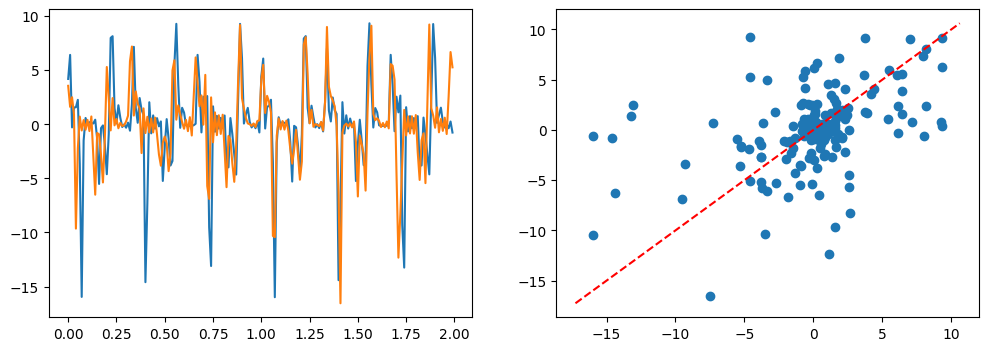

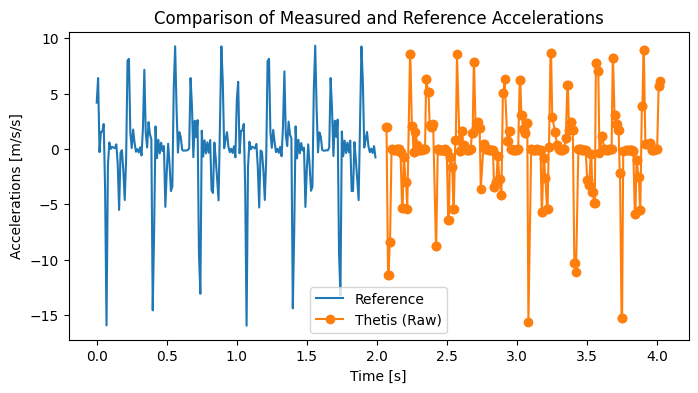

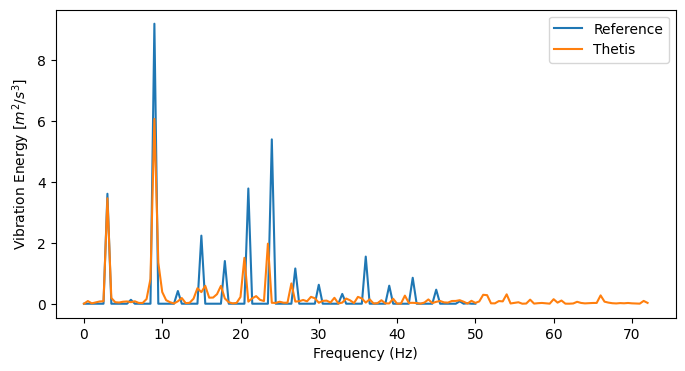

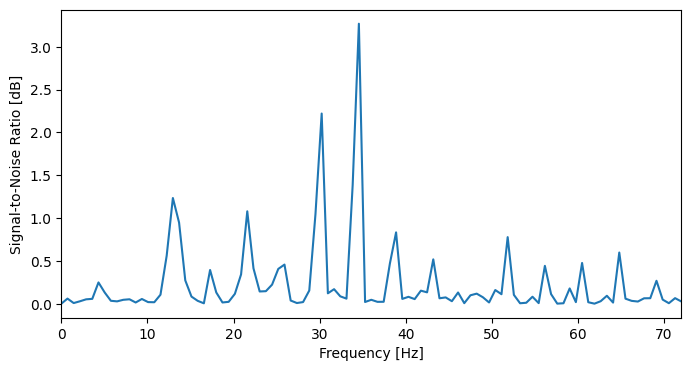

In [139]:
N_SAMPLES = len(epoch_data)
T_SAMPLE = np.max(daq_data.time)
DT = epoch_data - epoch_data[0]
ALL_DT = np.array([DT[x].total_seconds() for x in range(np.size(DT))], dtype=float)
F_SAMPLE = round(N_SAMPLES / np.max(DT).total_seconds())
print(ALL_DT)

print("Number of samples: ", N_SAMPLES) #DEBUG
print("Total Sample Time: ", T_SAMPLE) #DEBUG
print("Average Sample Rate: ", F_SAMPLE) #DEBUG

MEAS_START_INDEX = 300
TIME_WIDTH = 2 # Seconds
MEAS_END_INDEX = MEAS_START_INDEX + TIME_WIDTH * F_SAMPLE
x_meas = ALL_DT[MEAS_START_INDEX:MEAS_END_INDEX] # Window measurement timestamps
# x_meas = x_meas - x_meas[0] # Zero all the timestamps relative to the first value
# x_meas = [x_meas[x].total_seconds() for x in range(np.size(x_meas))] # Convert datetime timestamps to seconds
y_meas = raw_accel_data[MEAS_START_INDEX:MEAS_END_INDEX] # Window measurement accelerations

REF_START_INDEX = 0
REF_END_INDEX = TIME_WIDTH * 100
x_ref = daq_data.time[REF_START_INDEX:REF_END_INDEX] # Window reference timestamps
x_ref = x_ref - x_ref[0] # Zero all the timestamps relative to the first value
y_ref = daq_data.accel[REF_START_INDEX:REF_END_INDEX] # Window reference accelerations

# Resample the measured data to match the sample rate of reference sensor
x_resample = x_ref
y_resample = signal.resample(y_meas, len(y_ref))

# Calculate the cross-correlation between the two signals
corr = signal.correlate(y_ref, y_resample, mode='full', method='auto')

# Determine the time shift between the two signals
shift = np.argmax(corr) - len(y_ref) + 1
print(shift)

# Shift the measured sensor data by the determined time shift
y_resample = np.roll(y_resample, shift, axis=0)

# Make plots
fig_whole = plt.figure(1, figsize=(14,4))
fig_whole.suptitle("Acceleration Versus Time")
fig_whole.supxlabel("Time")
fig_whole.supylabel("Accelerations [m/s/s]")
ax_meas = fig_whole.add_subplot(1,2,1)
ax_meas.set_title("Thetis")
ax_meas.plot(ALL_DT, raw_accel_data)
ax_meas.axvline(epoch_data[MEAS_START_INDEX], linestyle='--', color='r')
ax_meas.axvline(epoch_data[MEAS_END_INDEX], linestyle='--', color='r')
ax_ref = fig_whole.add_subplot(1,2,2)
ax_ref.set_title("Reference")
ax_ref.plot(daq_data.time, daq_data.accel)

fig_resample = plt.figure(2, figsize=(12,4))
ax_resample = fig_resample.add_subplot(1,2,1)
ax_resample.plot(x_ref, y_ref)
ax_resample.plot(x_resample, y_resample)
ax_corr = fig_resample.add_subplot(1,2,2)
ax_corr.plot(y_ref, y_resample, 'o')
x = np.linspace(ax_corr.get_xlim()[0], ax_corr.get_xlim()[1])
ax_corr.plot(x, x, '--', color='red')

# Compare accelerometer measurements
fig_comp = plt.figure(3, figsize=(8,4))
ax_comp = fig_comp.add_subplot(1,1,1)
ax_comp.set_title("Comparison of Measured and Reference Accelerations")
ax_comp.plot(x_ref, y_ref)
ax_comp.plot(x_meas, y_meas, 'o-')
ax_comp.set_xlabel("Time [s]")
ax_comp.set_ylabel("Accelerations [m/s/s]")
ax_comp.legend(["Reference", "Thetis (Raw)"])

# Perform FFT
# X = np.fft.fft(y_meas)
# Y = np.fft.fft(y_ref)
# x_freqs = np.fft.fftfreq(len(X), d=1/F_SAMPLE)
# y_freqs = np.fft.fftfreq(len(Y), d=1/100)

# # Plot results
# fig_fft = plt.figure(4, figsize=(8, 4))
# ax_fft = fig_fft.add_subplot(1,1,1)
# ax_fft.plot(y_freqs, np.abs(Y))
# ax_fft.plot(x_freqs, np.abs(X))
# ax_fft.set_xlim([0, F_SAMPLE/2])
# ax_fft.set_xlabel('Frequency (Hz)')
# ax_fft.set_ylabel('Magnitude')
# ax_fft.legend(["Reference", "Thetis (Raw)"])
# ax_fft.grid(True)

# Perform PSD analysis
f_ref, psd_ref = signal.periodogram(y_ref, 100)
f_meas, psd_meas = signal.periodogram(y_meas, F_SAMPLE)
fig_psd = plt.figure(5, figsize=(8,4))
ax_psd = fig_psd.add_subplot(1,1,1)
ax_psd.plot(f_ref, psd_ref, label='Reference')
ax_psd.plot(f_meas, psd_meas, label='Thetis')
ax_psd.set_xlabel('Frequency (Hz)')
ax_psd.set_ylabel('Vibration Energy [$m^2/s^3$]')
ax_psd.legend()

# Perform SNR analysis
snr_freqs, snr = signal.periodogram(y_resample - y_ref, fs=F_SAMPLE)

fig_snr = plt.figure(6, figsize=(8,4))
ax_snr = fig_snr.add_subplot(1,1,1)
ax_snr.plot(snr_freqs, snr)
ax_snr.set_xlim([0, F_SAMPLE/2])
ax_snr.set_xlabel("Frequency [Hz]")
ax_snr.set_ylabel("Signal-to-Noise Ratio [dB]")

-1
0.4530245372838117


Text(0, 0.5, 'Signal-to-Noise Ratio (dB)')

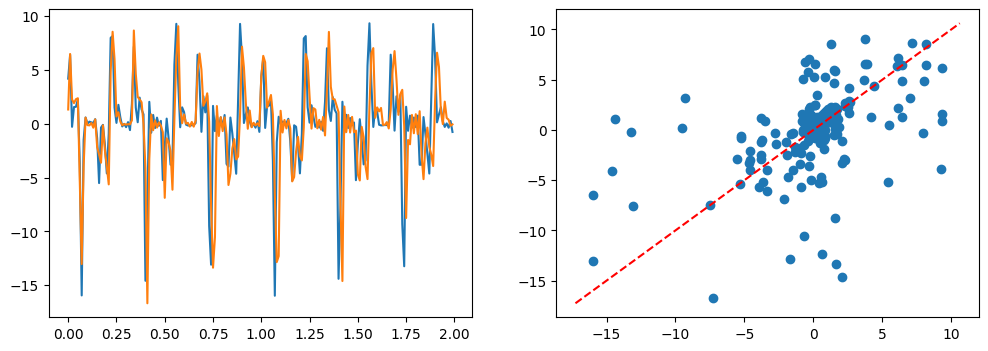

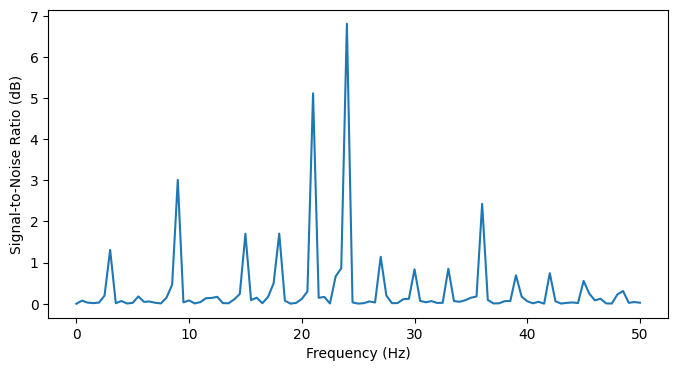

In [38]:
# Resample the sensor 2 data to match the sample rate of sensor 1
resampled_sensor2_data = signal.resample(y_meas, len(y_ref))

# Plot new data
fig_resample = plt.figure(figsize=(12,4))
ax_resample = fig_resample.add_subplot(1,2,1)
ax_resample.plot(x_ref, y_ref)
ax_resample.plot(x_ref, resampled_sensor2_data)
ax_corr = fig_resample.add_subplot(1,2,2)
ax_corr.plot(y_ref, resampled_sensor2_data, 'o')
x = np.linspace(ax_corr.get_xlim()[0], ax_corr.get_xlim()[1])
ax_corr.plot(x, x, '--', color='red')

# Calculate the cross-correlation between the two signals
corr = signal.correlate(y_ref, resampled_sensor2_data, mode='full', method='auto')

# Determine the time shift between the two signals
shift = np.argmax(corr) - len(y_ref) + 1
print(shift)

# Shift the measured sensor data by the determined time shift
shifted_sensor2_data = np.roll(resampled_sensor2_data, shift, axis=0)

# Calculate the correlation between the two signals
correlation = np.corrcoef(y_ref, resampled_sensor2_data)[0, 1]
print(correlation)

# Calculate the signal-to-noise ratio (SNR) as a function of measured frequency
frequencies, snr = signal.periodogram(resampled_sensor2_data - y_ref, fs=100)

fig_snr = plt.figure(figsize=(8,4))
ax_snr = fig_snr.add_subplot(1,1,1)
ax_snr.plot(frequencies, snr)
ax_snr.set_xlabel("Frequency (Hz)")
ax_snr.set_ylabel("Signal-to-Noise Ratio (dB)")